**Linear regression (a)**

In [1]:
# packages
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
from sklearn import model_selection
import matplotlib.pyplot as plt
from toolbox_02450 import rlr_validate

plt.style.use('fivethirtyeight')

In [3]:
# loading data
filename = 'data/glass.csv'
df = pd.read_csv(filename)

# defining x and y for the linear regression
#       all attributes except RI
X = np.array(df.iloc[:,2:10])
#       number of attributes
M = 8
#       RI
y = np.array(df.iloc[:,1])

In [4]:
# K-fold with a reqularizatoin loop (using rlr_validate)
K = 5
CV = model_selection.KFold(n_splits=K,shuffle=True)

error_test = np.zeros(K)
error_train = np.zeros(K)

# standardization
mu = np.mean(X,  axis = 0)
sigma = np.std(X, axis = 0)
X = (X - mu)/sigma




lambdas = np.power(10., np.linspace(-16,12,40))
w_rlr = np.empty((M,K))


opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X, y, lambdas)

for i, (train_index, test_index) in enumerate(CV.split(X)):
    X_train, X_test = X[train_index, :], X[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    lambdaI = opt_lambda * np.eye(M)

    w_rlr[:,i] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()

    error_train[i] = np.square(y_train-X_train @ w_rlr[:,i]).sum(axis=0)/y_train.shape[0]
    error_test[i] = np.square(y_test-X_test @ w_rlr[:,i]).sum(axis=0)/y_test.shape[0]





In [5]:
error_test

array([2.86279154, 2.49890853, 2.54860448, 2.4889111 , 2.50244443])

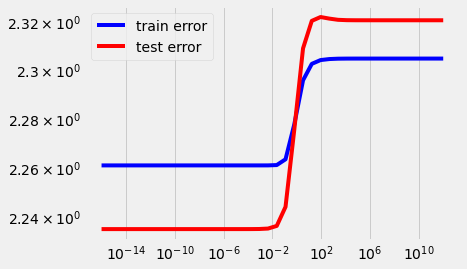

0
lambda =  1e-16


In [6]:
#plt.plot(lambdas, train_err_vs_lambda, 'b-', lambdas, test_err_vs_lambda, 'r-')
plt.loglog(lambdas, train_err_vs_lambda.T, 'b-',label="train error")
plt.loglog(lambdas, test_err_vs_lambda.T, 'r-', label="test error")
plt.legend()
plt.show()

# what is the mat-calculated min of the test error:
ind = np.argmin(test_err_vs_lambda)
print(ind)
print("lambda = ", lambdas[ind])
# that is the first entry (the smallest lambda)

In [7]:
assert lambdas[ind] != 1e-16
# zooming around the minimum
index_r = ind + 1
index_l = ind - 5
zoom = [i for i in range(index_l, index_r+1)]

plt.loglog(lambdas[zoom], train_err_vs_lambda.T[zoom], 'b-',label="train error")
plt.loglog(lambdas[zoom], test_err_vs_lambda.T[zoom], 'r-', label="test error")
plt.legend()
plt.show()



AssertionError: 

**Regression, part b**

Comparison of three models

In [2]:
# imports
import torch
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
from sklearn import model_selection
import matplotlib.pyplot as plt
from tqdm import tqdm


In [4]:
# loading data
filename = 'glass.csv'
df = pd.read_csv(filename)

# defining x and y for the linear regression
#       all attributes except RI
X = np.array(df.iloc[:,2:10])
#       number of attributes
M = 8
#       RI
y = np.array(df.iloc[:,1])

In [19]:
# TODO: Find out about Bias
# TODO: Base?
# TODO: ANN, i =1 ?
# TODO: is standardization only in relation to the mean and std of the TRAINING DATA?

# init for ANN
#n_hidden_units = 3
max_iter = 10000
tolerance = 1e-6
logging_frequency = 1000
best_final_loss = 1e100
n_replicates = 3



# model = lambda: torch.nn.Sequential(
#                     torch.nn.Linear(M, n_hidden_units), #M features to H hiden units
#                     # 1st transfer function, either Tanh or ReLU:
#                     #torch.nn.Tanh(),                            
#                     torch.nn.ReLU(),
#                     torch.nn.Linear(n_hidden_units, 1)) # H hidden units to 1 output neuron

loss_fn = torch.nn.MSELoss()


#K = K_outer = K_inner
K = 10

CV_outer = model_selection.KFold(n_splits=K,shuffle=True)

# lists we want to fill out every outer - loop - iteration :
h_i_list = np.zeros(K)
ANN_error_test = np.zeros(K)
ANN_error_train = np.zeros(K)
lambda_i = np.zeros(K)
Lin_error_test = np.zeros(K)
Lin_error_train = np.zeros(K)
Base_error_test = np.zeros(K)
Base_error_train = np.zeros(K)

lambdas = np.power(10., np.linspace(-16,9,40))
opt_lambda = np.zeros(K)
h = [i for i in range(1,11)]
opt_h = np.zeros(K)

##*OUTER LOOP*
for m, (train_index, test_index) in tqdm(enumerate(CV_outer.split(X))):
    X_train, X_test = X[train_index, :], X[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    # Standardization
    X_train = (X_train - np.mean(X_train))/np.std(X_train)
    X_test = (X_test - np.mean(X_test))/np.std(X_test)
    y_train = (y_train - np.mean(y_train))/np.std(y_train)
    y_test = (y_test - np.mean(y_test))/np.std(y_test)

    #init for optimal lambda
    w = np.empty((M,K,len(lambdas)))
    M = X_train.shape[1]
    train_error_lambda = np.empty((K,len(lambdas)))
    test_error_lambda = np.empty((K,len(lambdas)))
    j = 0
    
    #init for optimal h
    h_error_train = np.zeros(10)
    h_error_test = np.zeros(10)


    ##*INNER LOOP*
    CV_inner = model_selection.KFold(n_splits=K,shuffle=True)
    for j, (train_index_inner, test_index_inner) in enumerate(CV_inner.split(X_train, y_train)):
        # prinitng
        print("outer_loop: " + str(m+1) + "/10. inner_loop: " + str(j+1) + "/10.",end='\r')

        X_train_inner, X_test_inner = X_train[train_index_inner, :], X_train[test_index_inner, :]
        y_train_inner, y_test_inner = y_train[train_index_inner], y_train[test_index_inner]

        #standardization ?
        #mu[i,:] = np.mean(X_train, axis=0)
        #sigma[i,:] = np.std(X_train, axis=0)
        

        #finding optimal lambda
        # precompute terms
        Xty = X_train_inner.T @ y_train_inner
        XtX = X_train_inner.T @ X_train_inner
        for l in range(0,len(lambdas)):
            # Compute parameters for current value of lambda and current CV fold
            # note: "linalg.lstsq(a,b)" is substitue for Matlab's left division operator "\"
            lambdaI = lambdas[l] * np.eye(M)
            #lambdaI[0,0] = 0 # remove bias regularization 
            w[:,j,l] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
            # Evaluate training and test performance
            train_error_lambda[j,l] = np.power(y_train_inner-X_train_inner @ w[:,j,l].T,2).mean(axis=0)
            test_error_lambda[j,l] = np.power(y_test_inner-X_test_inner @ w[:,j,l].T,2).mean(axis=0)


        # finding best h
        X_train_inner, X_test_inner = torch.tensor(X_train_inner, dtype=torch.float), torch.tensor(X_test_inner, dtype=torch.float)
        y_train_inner, y_test_inner = torch.tensor(y_train_inner, dtype=torch.float), torch.tensor(y_test_inner, dtype=torch.float)
        y_test_inner = torch.reshape(y_test_inner, (y_test_inner.shape[0],1))
        y_train_inner = torch.reshape(y_train_inner, (y_train_inner.shape[0],1))

        n_hidden_units_inner = h[j]
        model_inner = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units_inner), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    #torch.nn.Tanh(),                            
                    torch.nn.ReLU(),
                    torch.nn.Linear(n_hidden_units_inner, 1)) # H hidden units to 1 output neuron

        oss_fn = torch.nn.MSELoss()

        for r in range(n_replicates):
            net_inner = model_inner()

            torch.nn.init.xavier_uniform_(net_inner[0].weight)
            torch.nn.init.xavier_uniform_(net_inner[2].weight)

            optimizer = torch.optim.Adam(net_inner.parameters())

            learning_curve = []
            old_loss = 1e6
            for i in range(max_iter):
                y_est = net_inner(X_train_inner)
                #y_class = torch.max(y_est, dim=1)[1]
                loss = loss_fn(y_est, y_train_inner)
                loss_value = loss.data.numpy()
                learning_curve.append(loss_value)


                p_delta_loss = np.abs(loss_value - old_loss)/old_loss
                if p_delta_loss < tolerance: break
                old_loss = loss_value


                #if (i != 0) & ((i+1) % logging_frequency == 0):
                #    print_str = '\t\t' + str(i+1) + '\t' + str(loss_value) + '\t' + str(p_delta_loss)
                #    print(print_str)
                optimizer.zero_grad(); loss.backward(); optimizer.step()

    

            if loss_value < best_final_loss:
                best_net = net_inner
                best_final_loss = loss_value
                best_learning_curve = learning_curve

        y_pred_inner = net_inner(X_test_inner)
        se_inner = (y_pred_inner.float() - y_test_inner.float())**2  # the squared error
        mse_inner = (sum(se_inner).type(torch.float)/len(y_test_inner)).data.numpy()
        h_error_test[j]  = mse_inner
        h_error_train[j] = best_final_loss # ikke helt korrekt men ved ikke om det er nødvændigt


    # opt_val_err = np.min(np.mean(test_error_lambda,axis=0))
    opt_lambda[m] = lambdas[np.argmin(np.mean(test_error_lambda,axis=0))]
    # train_err_vs_lambda = np.mean(train_error_lambda,axis=0)
    # test_err_vs_lambda = np.mean(test_error_lambda,axis=0)
    # mean_w_vs_lambda = np.squeeze(np.mean(w,axis=1))
    opt_h[m] = h[np.argmin(h_error_test)]


    ##*REGRESSION*
    # Baseline error-calculation
    Base_error_train[m] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    Base_error_test[m] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]

    # Linear regression
    lin = lm.Ridge(alpha=opt_lambda[m], fit_intercept=True).fit(X_train, y_train)

    # saving values
    Lin_error_train[m] = 1/X_train.shape[0] * np.sum(np.square(y_train - lin.predict(X_train)))
    Lin_error_test[m] = 1/X_test.shape[0] * np.sum(np.square(y_test - lin.predict(X_test)))

    #ANN
    X_train, X_test = torch.tensor(X_train, dtype = torch.float), torch.tensor(X_test, dtype=torch.float)
    y_train, y_test = torch.tensor(y_train, dtype = torch.float), torch.tensor(y_test, dtype=torch.float)
    y_test = torch.reshape(y_test, (y_test.shape[0],1))
    y_train = torch.reshape(y_train, (y_train.shape[0],1))

    

    model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, int(opt_h[m])), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    #torch.nn.Tanh(),                            
                    torch.nn.ReLU(),
                    torch.nn.Linear(int(opt_h[m]), 1)) # H hidden units to 1 output neuron

    # Training  loop
    for r in range(n_replicates):
        net = model()

        torch.nn.init.xavier_uniform_(net[0].weight)
        torch.nn.init.xavier_uniform_(net[2].weight)

        optimizer = torch.optim.Adam(net.parameters())

        learning_curve = []
        old_loss = 1e6
        for i in range(max_iter):
            y_est = net(X_train)
            #y_class = torch.max(y_est, dim=1)[1]
            loss = loss_fn(y_est, y_train)
            loss_value = loss.data.numpy()
            learning_curve.append(loss_value)


            p_delta_loss = np.abs(loss_value - old_loss)/old_loss
            if p_delta_loss < tolerance: break
            old_loss = loss_value

            optimizer.zero_grad(); loss.backward(); optimizer.step()

        if loss_value < best_final_loss:
            best_net = net
            best_final_loss = loss_value
            best_learning_curve = learning_curve
        

        
    # save loss for ANN
    y_pred = net(X_test)
    se = (y_pred.float() - y_test.float())**2  # the squared error
    mse = (sum(se).type(torch.float)/len(y_test)).data.numpy()

    ANN_error_test[m] = np.mean(mse)
    ANN_error_train[m] = best_final_loss



    # lin = lm.Ridge(alpha=opt_lambda, fit_intercept=True).fit(X_train_inner, y_train_inner)

    # # saving values
    # Lin_error_train[m] = 1/X_train_inner.shape[0] * np.sum(np.square(y_train_inner - lin.predict(X_train_inner)))
    # Lin_error_test[m] = 1/X_test_inner.shape[0] * np.sum(np.square(y_test_inner - lin.predict(X_test_inner)))
 



0it [00:00, ?it/s]

1it [01:08, 68.43s/it]

2it [02:40, 82.43s/it]

3it [03:45, 74.27s/it]

4it [05:04, 76.24s/it]

5it [06:21, 76.40s/it]

6it [07:38, 76.70s/it]

7it [08:45, 73.63s/it]

8it [10:03, 74.97s/it]

9it [11:18, 74.89s/it]

10it [12:35, 75.50s/it]


In [29]:




print("{:<15} | {:<15} {:<15} {:<15} {:<15} {:<15}".format('Outer fold i', 'h', 'E_ANN', 'lambda', 'E_lin', 'E_base'))
print("-----------------------------------------------------------------------------------------")
for i in range(10):
    print("{:<15} | {:<15} {:<15.3f} {:<15.6f} {:<15.3f} {:<15.7f}".format(i+1, int(opt_h[i]), ANN_error_test[i], opt_lambda[i], Lin_error_test[i], Base_error_test[i]))


Outer fold i    | h               E_ANN           lambda          E_lin           E_base         
-----------------------------------------------------------------------------------------
1               | 8               0.104           0.000035        0.140           1.0000000      
2               | 7               0.317           0.000035        0.311           1.0000000      
3               | 9               0.546           0.000000        0.558           1.0000000      
4               | 6               0.236           0.000000        0.240           1.0000000      
5               | 10              0.265           0.000035        0.155           1.0000000      
6               | 4               0.040           0.000002        0.034           1.0000000      
7               | 7               1.000           0.000008        0.186           1.0000000      
8               | 5               0.335           0.000035        0.293           1.0000000      
9               | 5         

**Artificial Neural Network**

Har skrevet træningsloopet ind fordi jeg ville lære det; men tænker bare det kan fjernes. Her er en start

In [12]:
import torch
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
from sklearn import model_selection
import matplotlib.pyplot as plt

In [13]:
# loading data
filename = 'glass.csv'
df = pd.read_csv(filename)

# standardizing
df_stand = (df - df.mean(axis = 0)) / df.std(axis = 0)
df_stand

,ID,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,-1.719943,0.870826,0.284287,1.251704,-0.690822,-1.124446,-0.670134,-0.145425,-0.352051,-0.585079,-0.846290
1,-1.703794,-0.248750,0.590433,0.634680,-0.170061,0.102080,-0.026152,-0.791877,-0.352051,-0.585079,-0.846290
2,-1.687644,-0.719631,0.149582,0.600016,0.190465,0.437760,-0.164148,-0.827010,-0.352051,-0.585079,-0.846290
3,-1.671494,-0.232286,-0.242285,0.697076,-0.310266,-0.052850,0.111844,-0.517838,-0.352051,-0.585079,-0.846290
4,-1.655344,-0.311315,-0.168810,0.648546,-0.410413,0.553957,0.081178,-0.623237,-0.352051,-0.585079,-0.846290
...,...,...,...,...,...,...,...,...,...,...,...
209,1.655344,-0.703166,0.896579,-1.861147,2.874386,-0.052850,-0.639468,0.156721,1.779805,-0.585079,2.005775
210,1.671494,-0.499008,1.851755,-1.861147,1.091782,0.528136,-0.762132,-0.391358,2.845733,-0.585079,2.005775
211,1.687644,0.752282,1.165987,-1.861147,1.151869,0.992924,-0.762132,-0.363251,2.946292,-0.585079,2.005775
212,1.703794,-0.610966,1.190479,-1.861147,0.991635,1.238229,-0.762132,-0.335145,2.805509,-0.585079,2.005775


In [1]:
X = torch.tensor(np.array(df_stand.iloc[:,1:10]), dtype=torch.float)
y = torch.tensor(np.array(df.iloc[:,10]), dtype=torch.long)
N, M =  X.shape
print(X.shape)
print(y.shape)
y[y>3] = y[y>3] - 1
y = y - 1

y

NameError: name 'torch' is not defined

In [66]:
n_hidden_units = 3

#number of classes
C = len(torch.unique(y))

model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    #torch.nn.Tanh(),                            
                    torch.nn.ReLU(),
                    torch.nn.Linear(n_hidden_units, C), # H hidden units to 1 output neuron
                    torch.nn.Softmax(dim=1) # final tranfer function
                    )

loss_fn = torch.nn.CrossEntropyLoss()

max_iter = 10000
print('Training model of type:\n{}\n'.format(str(model())))

K = 5
CV = model_selection.KFold(n_splits=K,shuffle=True)

error_test = np.zeros(K)
error_train = np.zeros(K)

n_replicates = 3
max_iter = 10000
tolerance = 1e-6
logging_frequency = 1000
best_final_loss = 1e100

for i, (train_index, test_index) in enumerate(CV.split(X,y)):
    X_train, X_test = torch.tensor(X[train_index, :], dtype=torch.float), torch.tensor(X[test_index, :], dtype=torch.float)
    y_train, y_test = torch.tensor(y[train_index]) , torch.tensor(y[test_index])

    # training

    for r in range(n_replicates):
        net = model()

        torch.nn.init.xavier_uniform_(net[0].weight)
        torch.nn.init.xavier_uniform_(net[2].weight)

        optimizer = torch.optim.Adam(net.parameters())

        learning_curve = []
        old_loss = 1e6
        for i in range(max_iter):
            y_est = net(X_train)
            #y_class = torch.max(y_est, dim=1)[1]
            loss = loss_fn(y_est, y_train)
            loss_value = loss.data.numpy()
            learning_curve.append(loss_value)


            p_delta_loss = np.abs(loss_value - old_loss)/old_loss
            if p_delta_loss < tolerance: break
            old_loss = loss_value


            if (i != 0) & ((i+1) % logging_frequency == 0):
                print_str = '\t\t' + str(i+1) + '\t' + str(loss_value) + '\t' + str(p_delta_loss)
                print(print_str)
            optimizer.zero_grad(); loss.backward(); optimizer.step()

        

        print('\t\tFinal Loss:')
        print_str = '\t\t' + str(i+1) + '\t' + str(loss_value) + '\t' + str(p_delta_loss)
        print(print_str)

        if loss_value < best_final_loss:
            best_net = net
            best_final_loss = loss_value
            best_learning_curve = learning_curve


TypeError: _unique2(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [16]:
softmax_logits = net(torch.tensor(X_test, dtype=torch.float))
y_test_est = (torch.max(softmax_logits, dim=1)[1]).data.numpy() 
e = (y_test_est != np.array(y_test))

print('Number of miss-classifications for ANN:\n\t {0} out of {1}'.format(sum(e),len(e)))


Number of miss-classifications for ANN:
	 17 out of 42


/var/folders/k7/4m0jgf1s5rggf6q996sfswf00000gn/T/ipykernel_16249/590878696.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  softmax_logits = net(torch.tensor(X_test, dtype=torch.float))


In [17]:
print(net.modules)
i = 0
weights = []
bias = []
for param in net.parameters():
    if i%2 == 0:
        weights.append(param.detach().numpy())
    else:
        bias.append(param.detach().numpy())
    i+=1

<bound method Module.modules of Sequential(
  (0): Linear(in_features=9, out_features=3, bias=True)
  (1): ReLU()
  (2): Linear(in_features=3, out_features=6, bias=True)
  (3): Softmax(dim=1)
)>


In [18]:
weights = []
bias = []
for layer in net.children():
    if isinstance(layer, torch.nn.Linear):
        print(layer.state_dict()['bias'])
        bias.append(np.transpose(layer.state_dict()['bias'].numpy()))
        print(layer.state_dict()['weight'])
        weights.append(np.transpose(layer.state_dict()['weight'].numpy()))

tensor([ 1.3495,  1.0251, -0.4522])
tensor([[-2.8173,  0.8316,  0.1971,  1.5000,  1.0523, -1.3251, -1.6998,  1.0321,
         -3.6185],
        [ 3.1418,  0.3935,  2.6626, -1.3520,  1.5215,  0.1068, -2.2186, -1.6910,
         -2.8521],
        [-0.9500,  0.9564, -0.9038,  0.9514,  0.4200, -1.1637, -1.3553,  2.0192,
         -1.5421]])
tensor([-1.3544,  3.7928, -2.5341, -1.4596, -2.8889, -2.5110])
tensor([[-4.2122,  4.5032,  1.4497],
        [ 2.9368, -3.0364, -3.3082],
        [-0.3448, -1.5074, -0.0093],
        [-1.4099, -0.5233, -0.1202],
        [-1.4458, -0.7441, -0.6395],
        [ 0.9712, -2.0031,  1.6596]])


In [19]:
print(weights)
print(bias)
for e in weights:
    print(e.shape) 
for e in bias:
    print(e.shape) 

[array([[-2.8172636 ,  3.1417522 , -0.9500293 ],
       [ 0.8316336 ,  0.39354253,  0.95638615],
       [ 0.19709288,  2.6625786 , -0.9037988 ],
       [ 1.500012  , -1.351989  ,  0.9514345 ],
       [ 1.0523428 ,  1.5214711 ,  0.41999385],
       [-1.325108  ,  0.10678095, -1.1636853 ],
       [-1.6997876 , -2.2185533 , -1.3553133 ],
       [ 1.0320883 , -1.690969  ,  2.0192459 ],
       [-3.618461  , -2.85213   , -1.5421441 ]], dtype=float32), array([[-4.2121587 ,  2.9367895 , -0.34478524, -1.4099004 , -1.4457965 ,
         0.9711859 ],
       [ 4.503188  , -3.0363822 , -1.5073771 , -0.5233441 , -0.74409807,
        -2.0030594 ],
       [ 1.4496875 , -3.3081808 , -0.00929562, -0.12018222, -0.63945395,
         1.659587  ]], dtype=float32)]
[array([ 1.3494762 ,  1.0251318 , -0.45215616], dtype=float32), array([-1.3543559,  3.7927592, -2.5341039, -1.4595776, -2.8889365,
       -2.5110013], dtype=float32)]
(9, 3)
(3, 6)
(3,)
(6,)


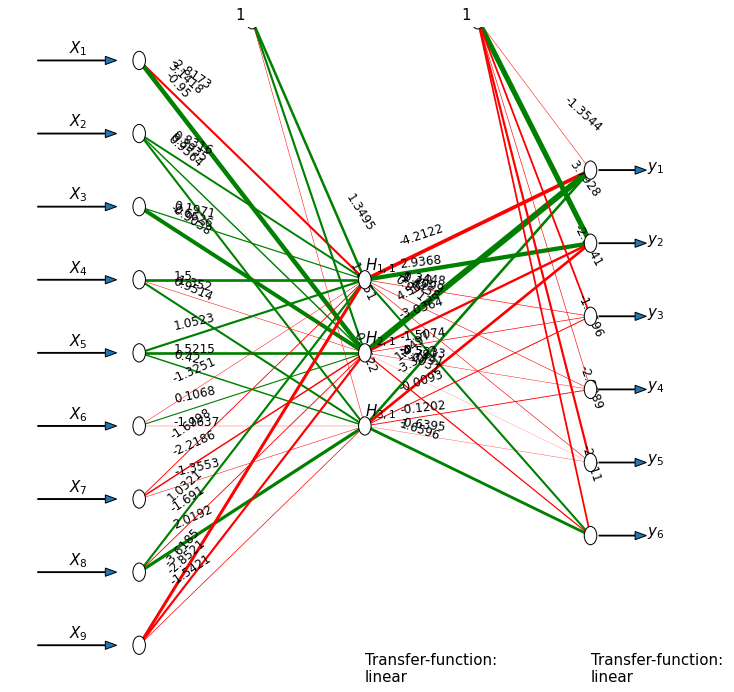

In [20]:
from toolbox_02450 import draw_neural_net


draw_neural_net(weights, bias, ['linear','linear'])

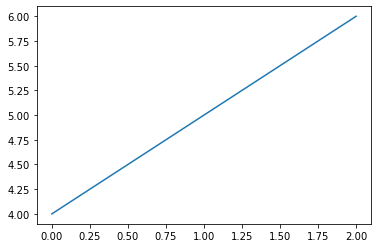

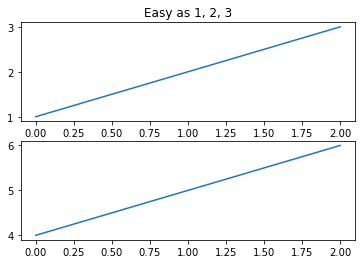

In [2]:
import matplotlib.pyplot as plt
plt.figure(1)                # the first figure
plt.subplot(211)             # the first subplot in the first figure
plt.plot([1, 2, 3])
plt.subplot(212)             # the second subplot in the first figure
plt.plot([4, 5, 6])


plt.figure(2)                # a second figure
plt.plot([4, 5, 6])          # creates a subplot() by default

plt.figure(1)                # first figure current;
                             # subplot(212) still current
plt.subplot(211)             # make subplot(211) in the first figure
                             # current
plt.title('Easy as 1, 2, 3')
plt.show()